## Building Autoencoders in Keras
https://blog.keras.io/building-autoencoders-in-keras.html

In Tensorflow: https://www.tensorflow.org/tutorials/generative/autoencoder

**CS480/680 Lecture 20: Autoencoders - Pascal Poupart**:

https://www.youtube.com/watch?v=E28CVTbNoSA&list=PLdAoL1zKcqTW-uzoSVBNEecKHsnug_M0k&index=28

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import layers

In [2]:
# this is the size of our encoded representations
encoding_dim = 32     # compression of factor 784/32 = 24.5, assuming the input is 784

In [13]:
# this is our input image
input_img = keras.Input(shape=(784,))

# encoded is the encoded representation of the input
encoded = layers.Dense(32, activation='relu')(input_img)

# decoded is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

Let's also create a separate encoder model, as well as the decoder model

In [14]:
# this model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

# this is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(32,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

Now, let's train our autoencoder to reconstruct MNIST digits
* First, we'll configure our model to use per-pixel binary crossentropy loss, and the Adam optimizer

Note: It makes sense to use binary cross-entropy here as it is a measure of the loss of the neural network, or its error in making predictions.

In [15]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Prepare our input data. We're using MNIST digits, and we're discarding the labels (since we are only interested in encoding/decoding the input images).

In [2]:
from keras.datasets import mnist

In [4]:
(x_train, _), (x_test, _) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [8]:
x_train.shape[1:]

(28, 28)

We will normalize all values to between 0 and 1, and we will flatten the 28x28 images into vectors of size 784

In [9]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Now, train the model using x_train as both the input and the target, for 50 epochs. The encoder will learn to compress the dataset from 784 dimensions to the latent space (here, we set it to 32), and the decoder will learn to reconstruct the original images.

In [16]:
autoencoder.fit(x_train, x_train,
               epochs=50,
               batch_size=256,
               shuffle=True,
               validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 2s 6ms/step - loss: 0.2750 - val_loss: 0.1918
Epoch 2/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1718 - val_loss: 0.1536
Epoch 3/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1445 - val_loss: 0.1343
Epoch 4/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1293 - val_loss: 0.1219
Epoch 5/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1185 - val_loss: 0.1130
Epoch 6/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1108 - val_loss: 0.1067
Epoch 7/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1055 - val_loss: 0.1022
Epoch 8/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1018 - val_loss: 0.0991
Epoch 9/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0991 - val_loss: 0.0968
Epoch 10/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0973 - val_loss: 0.0953

After 50 epochs, the autoencoder seems to reach a stable train/validation loss value of about 0.09. We can try to visualize the reconstructed inputs and the encoded representation.

In [18]:
# encode and decode some digits, take from the test set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 1s 1ms/step


In [19]:
encoded_imgs.mean()

8.880351

In [10]:
def plot_digits():
    n = 10    # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(10):
        # display original images
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    
        # display reconstruction
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

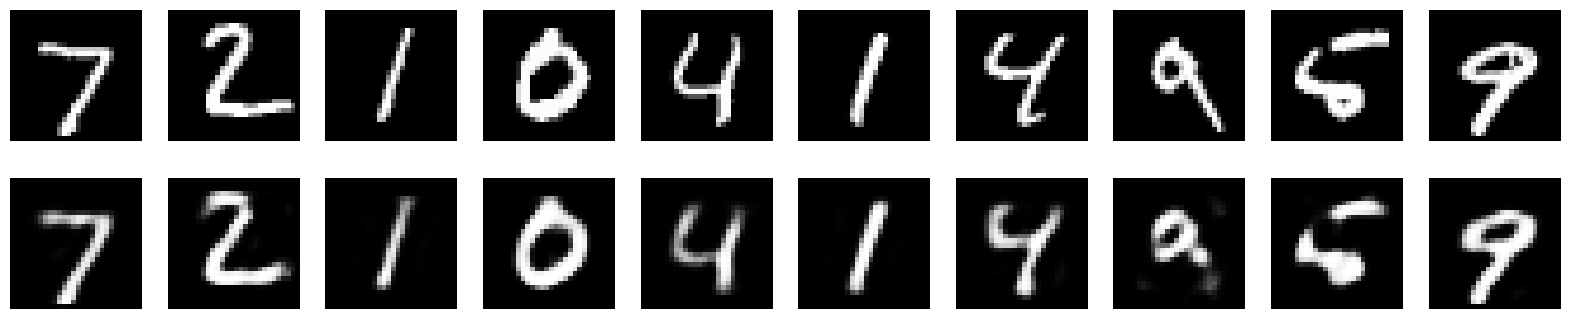

In [21]:
plot_digits()

The top row is the original digits, and the bottom row is the reconstructed digits. We are losing quite a bit of detail with this basic approach.

### Adding a sparsity constraint on the encoded representations
In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). But another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an activity_regularizer to our Dense layer:

In [22]:
from keras import regularizers

In [23]:
input_img = keras.Input(shape=(784,))

# add a Dense layer with an L1 activity regularizer
encoded = layers.Dense(32, activation='relu',
                      activity_regularizer=regularizers.l1(10e-5))(input_img)

decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_img, decoded)

In [24]:
encoder = keras.Model(input_img, encoded)

encoded_input = keras.Input(shape=(32,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

Let's train this model for 100 epochs (with the added regularization the model is less likely to overfit and can be trained longer). The models ends with a train loss of 0.11 and test loss of 0.10. The difference between the two is mostly due to the regularization term being added to the loss during training (worth about 0.01).

In [25]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

hist = autoencoder.fit(x_train, x_train,
                       epochs=100,
                       batch_size=256,
                       shuffle=True,
                       verbose=0,
                       validation_data=(x_test, x_test))

In [28]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 0s 1ms/step


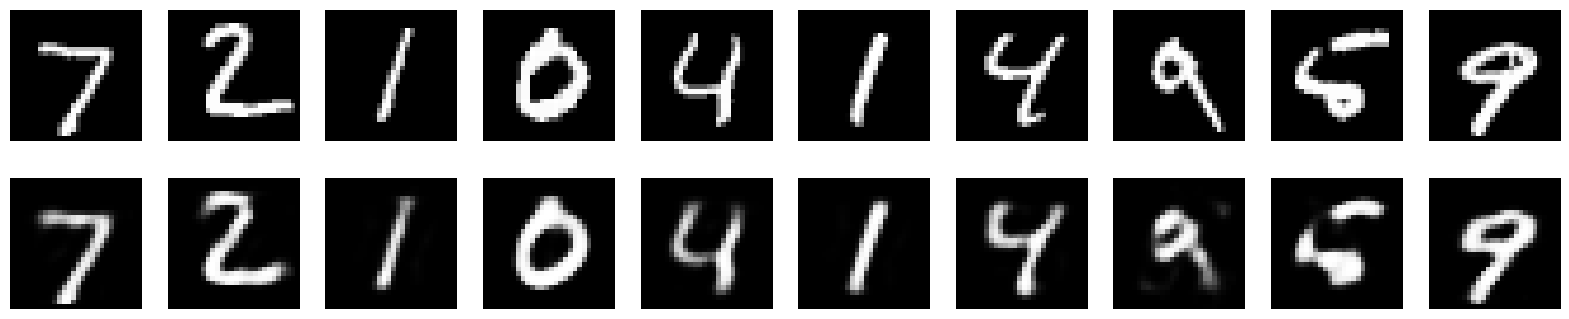

In [29]:
plot_digits()

In [30]:
encoded_imgs.mean()    # compare to our previous encoded_imgs.mean() of 8.822573

1.2822392

They look pretty similar to the previous model, the only significant difference being the sparsity of the encoded representations. encoded_imgs.mean() yields a value 3.33 (over our 10,000 test images), whereas with the previous model the same quantity was 7.30. So our new model yields encoded representations that are twice sparser.

### Deep Autoencoder
We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers.

In [31]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

In [32]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

hist = autoencoder.fit(x_train, x_train,
                      epochs=100,
                      batch_size=256,
                      shuffle=True,
                      verbose=0,
                      validation_data=(x_test, x_test))

After 100 epochs, it reaches a train and validation loss of ~0.08, a bit better than our previous models. Our reconstructed digits look a bit better too:

In [34]:
encoder = keras.Model(input_img, encoded)

encoded_input = keras.Input(shape=(32,))

decoder_layer = autoencoder.layers[-3](encoded_input)
decoder_layer = autoencoder.layers[-2](decoder_layer)
decoder_layer = autoencoder.layers[-1](decoder_layer)

decoder = keras.Model(encoded_input, decoder_layer)

In [36]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 1s 2ms/step


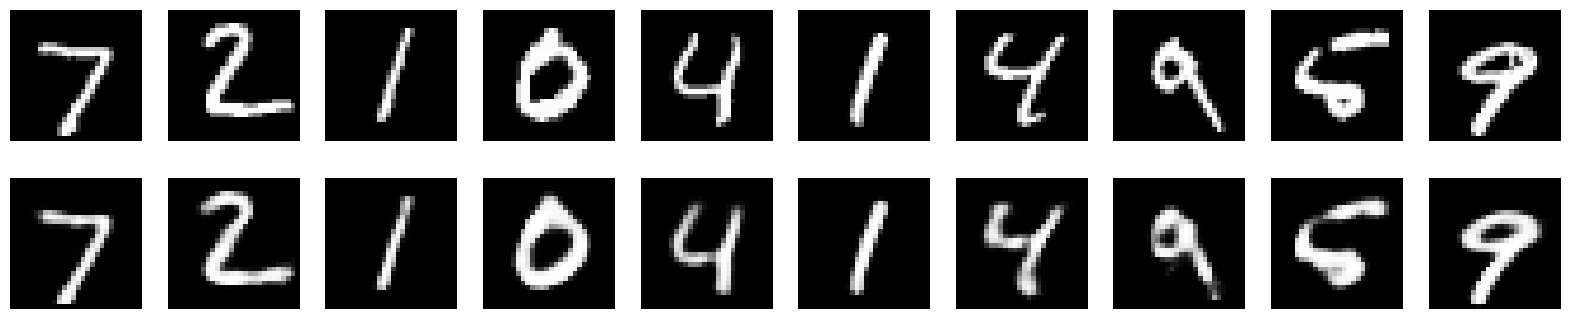

In [37]:
plot_digits()

### Convolutional Autoencoder
Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders -- they simply perform much better.

Let's implement one. The encoder will consist in a stack of `Conv2D` and `MaxPooling2D` layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of `Conv2D` and `UpSampling2D` layers.

In [4]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [5]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print('x_train dim:', x_train.shape)
print('x_test dim:', x_test.shape)
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
print('After reshaped:\nx_train dim:', x_train.shape)
print('x_train dim:', x_train.shape)

x_train dim: (60000, 28, 28)
x_test dim: (10000, 28, 28)
After reshaped:
x_train dim: (60000, 28, 28, 1)
x_train dim: (60000, 28, 28, 1)


Let's train this model for 50 epochs. For the sake of demonstrating how to visualize the results of a model during training, we will be using the TensorFlow backend and the TensorBoard callback.

First, let's open up a terminal and start a TensorBoard server that will read logs stored at /tmp/autoencoder

Then let's train our model. In the callbacks list we pass an instance of the TensorBoard callback. After every epoch, this callback will write logs to /tmp/autoencoder, which can be read by our TensorBoard server. This allows us to monitor training in the TensorBoard web interface (by navighating to http://0.0.0.0:6006)

In [6]:
from keras.callbacks import TensorBoard

In [7]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/20
469/469 [==============================] - 110s 232ms/step - loss: 0.2105 - val_loss: 0.1445
Epoch 2/20
469/469 [==============================] - 125s 267ms/step - loss: 0.1347 - val_loss: 0.1260
Epoch 3/20
469/469 [==============================] - 105s 224ms/step - loss: 0.1230 - val_loss: 0.1185
Epoch 4/20
469/469 [==============================] - 100s 213ms/step - loss: 0.1174 - val_loss: 0.1139
Epoch 5/20
469/469 [==============================] - 101s 214ms/step - loss: 0.1137 - val_loss: 0.1108
Epoch 6/20
469/469 [==============================] - 95s 202ms/step - loss: 0.1109 - val_loss: 0.1087
Epoch 7/20
469/469 [==============================] - 88s 188ms/step - loss: 0.1088 - val_loss: 0.1070
Epoch 8/20
469/469 [==============================] - 96s 204ms/step - loss: 0.1072 - val_loss: 0.1059
Epoch 9/20
469/469 [==============================] - 91s 193ms/step - loss: 0.1059 - val_loss: 0.1041
Epoch 10/20
469/469 [==============================] - 104s 221ms/st

The model converges to a loss of 0.094 (50 epochs), significantly better than our previous models (this is in large part due to the higher entropic capacity of the encoded representation, 128 dimensions vs. 32 previously). Let's take a look at the reconstructed digits:

In [8]:
decoded_imgs = autoencoder.predict(x_test)

313/313 [==============================] - 2s 4ms/step


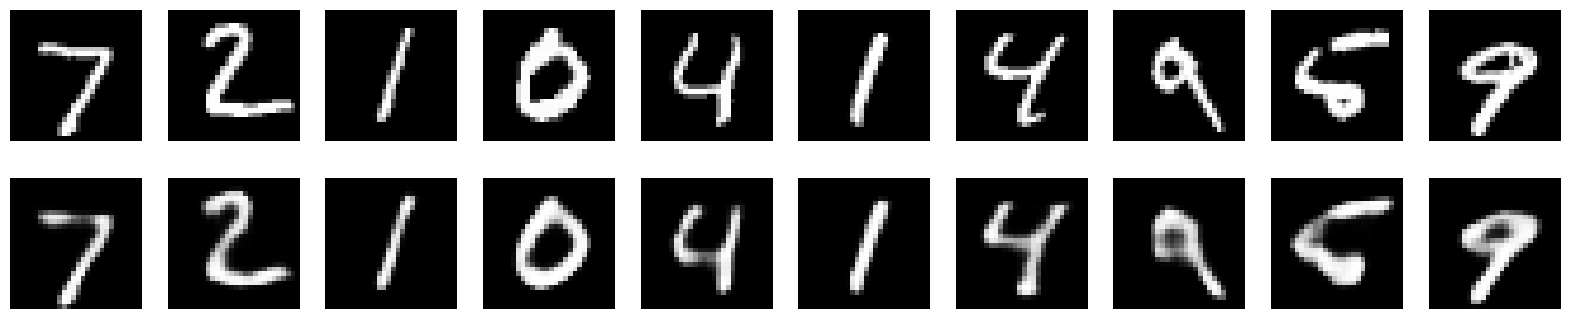

In [13]:
plot_digits()

We can also have a look at the 128-dimensional encoded representations. These representations are 4x4x8, and so we reshape them to 4x32 in order to be able to display them as grayscale images.

In [14]:
encoder = keras.Model(input_img, encoded)

encoded_imgs = encoder.predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [15]:
encoded_imgs.shape

(10000, 4, 4, 8)

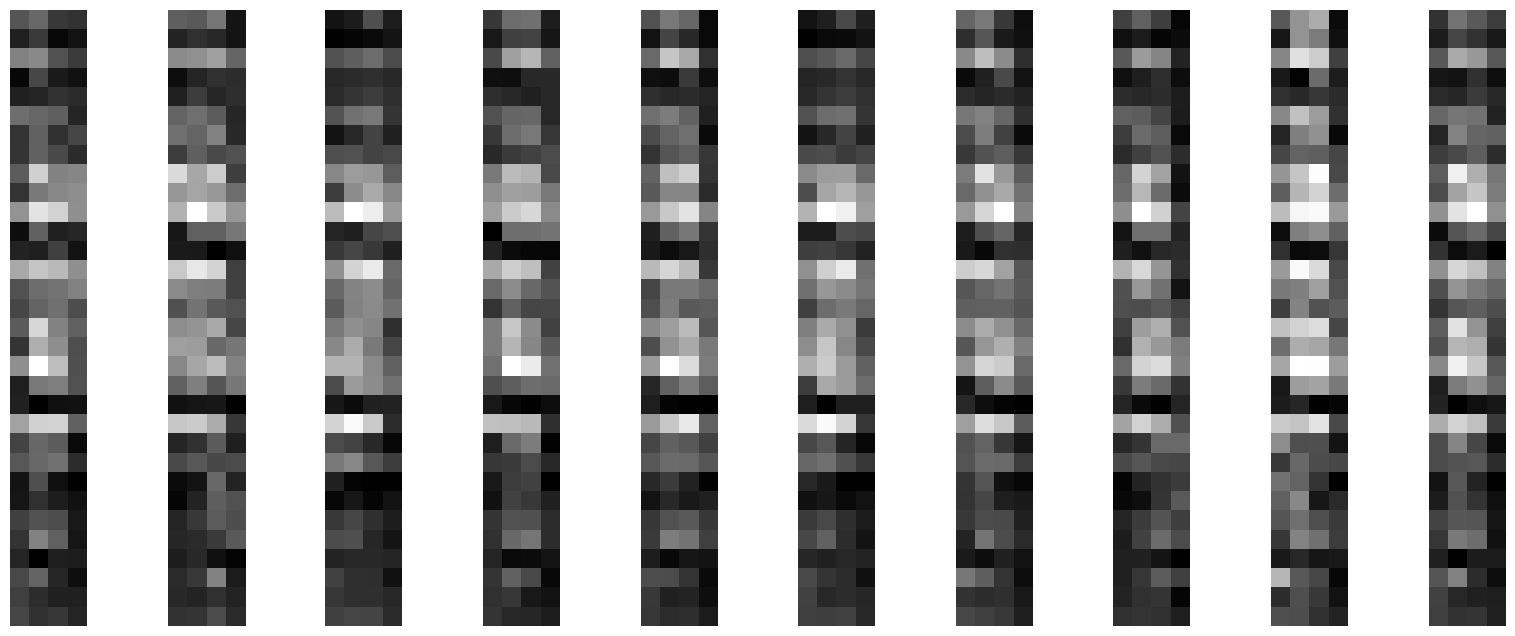

In [16]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape((4, 4*8)).T, cmap='gray')
    plt.axis('off')

### Application to Image Denoising
Let's put our convolutional autoencoder to work on an image denoising problem. It's simple: we will train the autoencoder to map noisy digits images to clean digits images.

Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [32]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

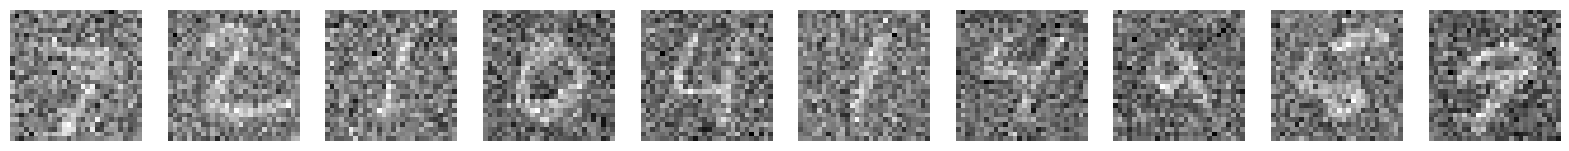

In [33]:
# Here's what the noisy digits look like if we didn't clip
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

In [34]:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

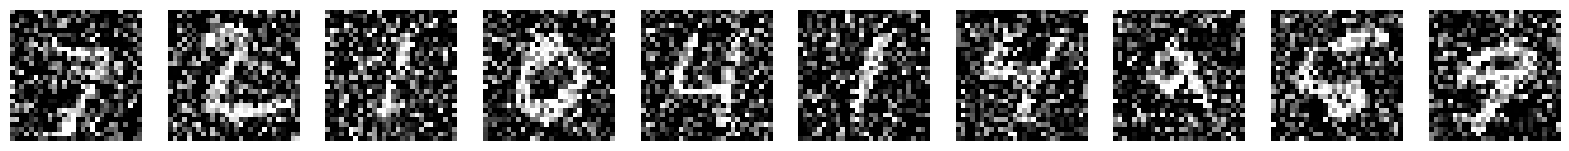

In [35]:
# Here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

Can our autoencoder learn to recover the original digits? Let's find out.

Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slightly different model with more filters per layer.

In [36]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point, the representation is (7, 7, 32)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [38]:
hist = autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                verbose=0,
                validation_data=(x_test_noisy, x_test),)
                #callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

In [43]:
decoded_imgs = autoencoder.predict(x_test)

313/313 [==============================] - 2s 6ms/step


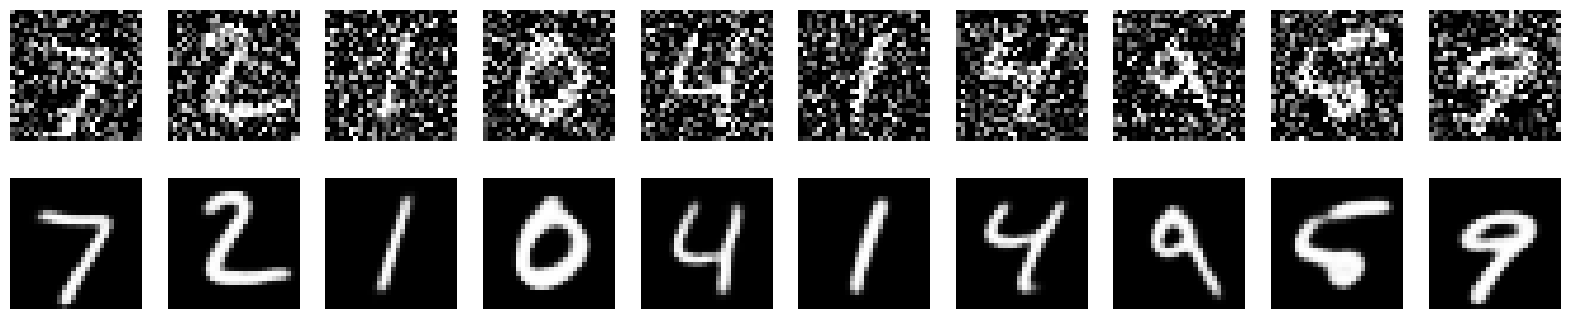

In [47]:
n = 10    # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(10):
    # display noisy images
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    
    # display reconstruction
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

It seems to work pretty well. If you scale this process to a bigger convnet, you can start building document denoising or audio denoising models. 

### Variational Autoencoder (VAE)
VAE is a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary functions, you are learning the parameter of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples. A VAE is a 'generative model'.

How does a variational autoencoder work? First, an encoder network turns the input samples x into 2 parameters in a latent space, which we will note as `z_mean` and `z_log_sigma`. Then, we randomly sample similar points `z` from the latent normal distribution that is assumed to generate the data, via `z = z_mean + exp(z_log_sigma) * epsilon`, where epsilon is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the model are trained via two loss functions: a reconstruction loss, forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

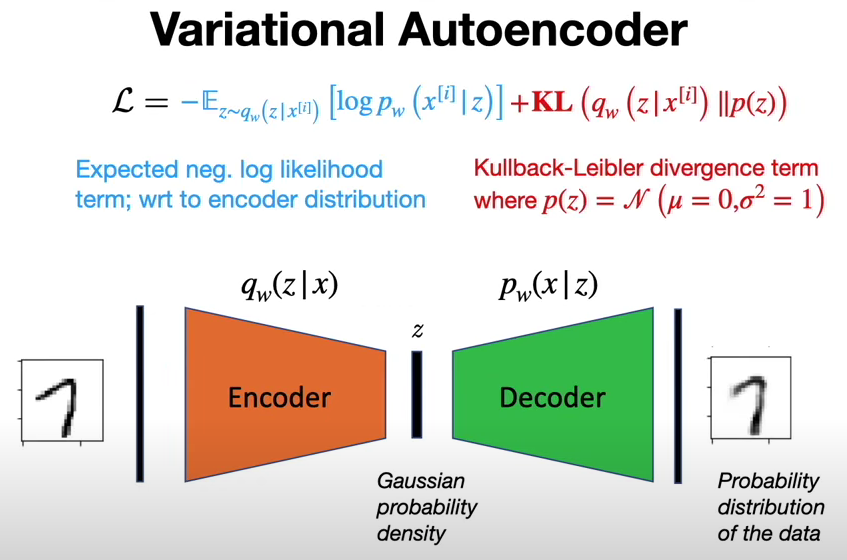

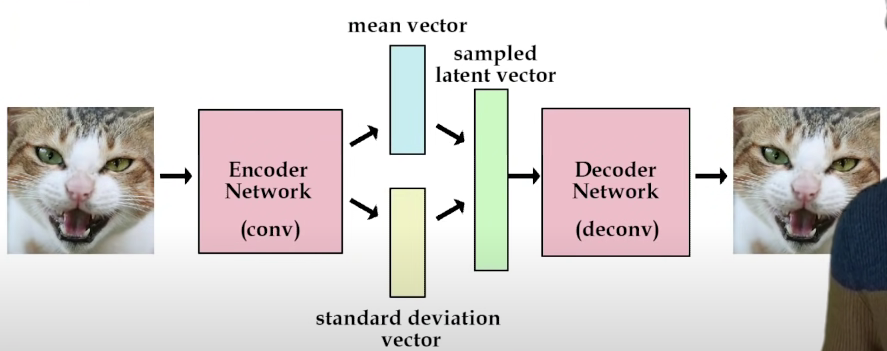

**Reparameterization Trick**

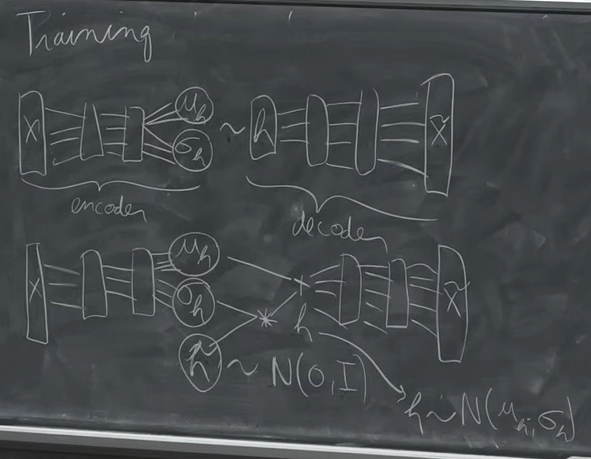

First, here's our encoder network, mapping inputs to our latent distribution parameters:

In [4]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

We can use these parameters to sample new similar points from the latent space:

In [5]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

Finally, we can map these sampled latent points back to reconstructed inputs:

In [6]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

What we've done so far allows us to instantiate 3 models:
* An end-to-end autoencoder mapping inputs to reconstructions
* An encoder mapping inputs to the latent space
* A generator that can take points on the latent space and will output the corresponding reconstructed samples

We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

In [8]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

Train our VAE on MNIST digits:

In [10]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

hist = vae.fit(x_train, x_train, epochs=100, batch_size=32, verbose=0,
               validation_data=(x_test, x_test))

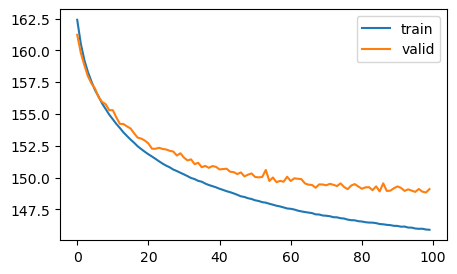

In [16]:
plt.figure(figsize=(5, 3))
plt.plot(np.arange(100), hist.history['loss'], label='train')
plt.plot(np.arange(100), hist.history['val_loss'], label='valid')
plt.legend();

Because our latent space is two-dimensional, there are a few visualization that can be done at this point. One is to look at the neighborhoods of different classes on the latent 2D plane.

In [17]:
x_test_encoded = encoder.predict(x_test, batch_size=32)

313/313 [==============================] - 1s 2ms/step


In [24]:
x_test_encoded

[array([[-0.67967004,  0.03343956],
        [ 0.5674232 , -0.08521698],
        [-2.1454382 , -1.6296144 ],
        ...,
        [-0.46297544,  0.01742242],
        [ 0.00655082, -0.11594719],
        [ 0.2647989 ,  0.20968735]], dtype=float32),
 array([[-1.3994654 , -1.5658982 ],
        [-1.8486817 , -1.8678579 ],
        [-0.52324235, -0.8058959 ],
        ...,
        [-1.6666058 , -1.649218  ],
        [-2.0400388 , -1.6119772 ],
        [-1.9382752 , -1.7744468 ]], dtype=float32),
 array([[-0.6906026 ,  0.02896213],
        [ 0.57184273, -0.0874519 ],
        [-2.1608133 , -1.5981714 ],
        ...,
        [-0.46371645,  0.00870539],
        [ 0.01609879, -0.11592303],
        [ 0.2756048 ,  0.21965197]], dtype=float32)]

In [30]:
np.stack(x_test_encoded, axis=0)

array([[[-0.67967004,  0.03343956],
        [ 0.5674232 , -0.08521698],
        [-2.1454382 , -1.6296144 ],
        ...,
        [-0.46297544,  0.01742242],
        [ 0.00655082, -0.11594719],
        [ 0.2647989 ,  0.20968735]],

       [[-1.3994654 , -1.5658982 ],
        [-1.8486817 , -1.8678579 ],
        [-0.52324235, -0.8058959 ],
        ...,
        [-1.6666058 , -1.649218  ],
        [-2.0400388 , -1.6119772 ],
        [-1.9382752 , -1.7744468 ]],

       [[-0.6906026 ,  0.02896213],
        [ 0.57184273, -0.0874519 ],
        [-2.1608133 , -1.5981714 ],
        ...,
        [-0.46371645,  0.00870539],
        [ 0.01609879, -0.11592303],
        [ 0.2756048 ,  0.21965197]]], dtype=float32)

In [27]:
x_test_encoded_stacked = np.stack(x_test_encoded, axis=0)

In [31]:
x_test_encoded_stacked.shape

(3, 10000, 2)

In [28]:
x_test_encoded_stacked[:, 0]

array([[-0.67967004,  0.03343956],
       [-1.3994654 , -1.5658982 ],
       [-0.6906026 ,  0.02896213]], dtype=float32)

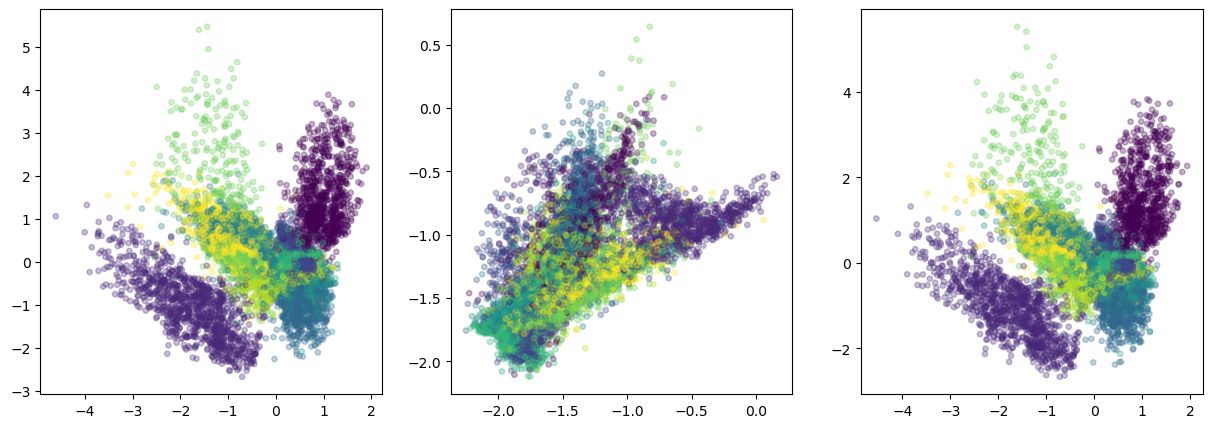

In [37]:
plt.figure(figsize=(15, 5))
for i in range(x_test_encoded_stacked.shape[0]):
    plt.subplot(1, 3, i+1)
    plt.scatter(x_test_encoded_stacked[i, :, 0], x_test_encoded_stacked[i, :, 1], c=y_test, s=15, alpha=0.3)

Each of these colored clusters is a type of digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space).

Because the VAE is a generative model, we can also use it to generate new digits! Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.

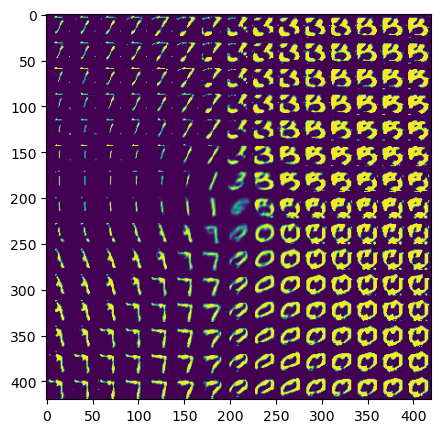

In [40]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(5, 5))
plt.imshow(figure)
plt.show()

In [3]:
import tensorflow as tf

In [ ]:
# Gaussian MLP as encoder
def gaussian_MLP_encoder(x, n_hidden, n_output, keep_prob):
    with tf.variable_scope("gaussian_MLP_encoder"):
        # initializers
        w_init = tf.contrib.layers.variance_scaling_initializer()
        b_init = tf.constant_initializer(0.)

        # 1st hidden layer
        w0 = tf.get_variable('w0', [x.get_shape()[1], n_hidden], initializer=w_init)
        b0 = tf.get_variable('b0', [n_hidden], initializer=b_init)
        h0 = tf.matmul(x, w0) + b0
        h0 = tf.nn.elu(h0)
        h0 = tf.nn.dropout(h0, keep_prob)

        # 2nd hidden layer
        w1 = tf.get_variable('w1', [h0.get_shape()[1], n_hidden], initializer=w_init)
        b1 = tf.get_variable('b1', [n_hidden], initializer=b_init)
        h1 = tf.matmul(h0, w1) + b1
        h1 = tf.nn.tanh(h1)
        h1 = tf.nn.dropout(h1, keep_prob)

        # output layer
        # borrowed from https: // github.com / altosaar / vae / blob / master / vae.py
        wo = tf.get_variable('wo', [h1.get_shape()[1], n_output * 2], initializer=w_init)
        bo = tf.get_variable('bo', [n_output * 2], initializer=b_init)
        gaussian_params = tf.matmul(h1, wo) + bo

        # The mean parameter is unconstrained
        mean = gaussian_params[:, :n_output]
        # The standard deviation must be positive. Parametrize with a softplus and
        # add a small epsilon for numerical stability
        stddev = 1e-6 + tf.nn.softplus(gaussian_params[:, n_output:])

    return mean, stddev

# Bernoulli MLP as decoder
def bernoulli_MLP_decoder(z, n_hidden, n_output, keep_prob, reuse=False):

    with tf.variable_scope("bernoulli_MLP_decoder", reuse=reuse):
        # initializers
        w_init = tf.contrib.layers.variance_scaling_initializer()
        b_init = tf.constant_initializer(0.)

        # 1st hidden layer
        w0 = tf.get_variable('w0', [z.get_shape()[1], n_hidden], initializer=w_init)
        b0 = tf.get_variable('b0', [n_hidden], initializer=b_init)
        h0 = tf.matmul(z, w0) + b0
        h0 = tf.nn.tanh(h0)
        h0 = tf.nn.dropout(h0, keep_prob)

        # 2nd hidden layer
        w1 = tf.get_variable('w1', [h0.get_shape()[1], n_hidden], initializer=w_init)
        b1 = tf.get_variable('b1', [n_hidden], initializer=b_init)
        h1 = tf.matmul(h0, w1) + b1
        h1 = tf.nn.elu(h1)
        h1 = tf.nn.dropout(h1, keep_prob)

        # output layer-mean
        wo = tf.get_variable('wo', [h1.get_shape()[1], n_output], initializer=w_init)
        bo = tf.get_variable('bo', [n_output], initializer=b_init)
        y = tf.sigmoid(tf.matmul(h1, wo) + bo)

    return y

# Gateway
def autoencoder(x_hat, x, dim_img, dim_z, n_hidden, keep_prob):
    # encoding
    mu, sigma = gaussian_MLP_encoder(x_hat, n_hidden, dim_z, keep_prob)

    # sampling by re-parameterization technique
    z = mu + sigma * tf.random_normal(tf.shape(mu), 0, 1, dtype=tf.float32)

    # decoding
    y = bernoulli_MLP_decoder(z, n_hidden, dim_img, keep_prob)
    y = tf.clip_by_value(y, 1e-8, 1 - 1e-8)

    # loss
    marginal_likelihood = tf.reduce_sum(x * tf.log(y) + (1 - x) * tf.log(1 - y), 1)
    KL_divergence = 0.5 * tf.reduce_sum(tf.square(mu) + tf.square(sigma) - tf.log(1e-8 + tf.square(sigma)) - 1, 1)

    marginal_likelihood = tf.reduce_mean(marginal_likelihood)
    KL_divergence = tf.reduce_mean(KL_divergence)

    ELBO = marginal_likelihood - KL_divergence

    loss = -ELBO

    return y, z, loss, -marginal_likelihood, KL_divergence


def decoder(z, dim_img, n_hidden):

    y = bernoulli_MLP_decoder(z, n_hidden, dim_img, 1.0, reuse=True)

    return y